In [1]:
%load_ext autoreload 
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import random
import tqdm
import datetime
import seaborn as sns

### Download map

![Cordinates for interesting area from bboxfinder.com](bbox.png)

### Prepare data

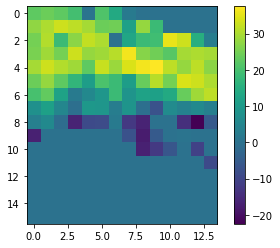

In [3]:
dBZ_radar = np.load('radar_regression.npy')

from radar import marshal_palmer
p_radar = marshal_palmer(dBZ_radar)

plt.imshow(dBZ_radar)
plt.colorbar()

In [4]:
dBZ_radar.shape

(16, 14)

### Polynomial fit and MSE

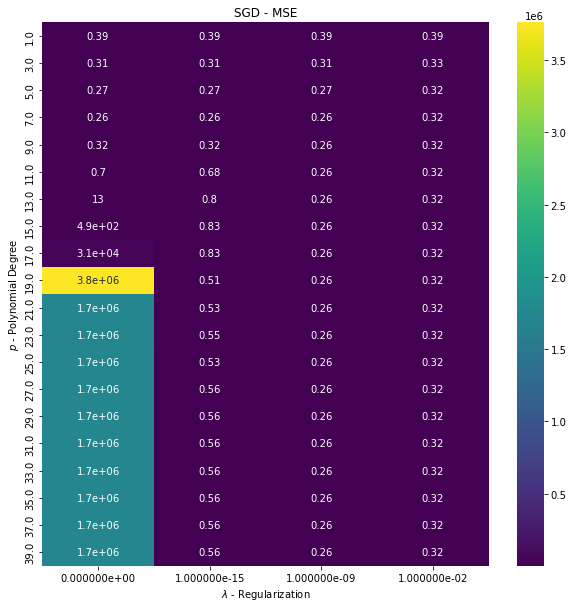

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as OLS
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

polynomial_degrees = np.arange(1, 40, 2)
regularization = np.array([10**(-13), 10**(-9), 10**(-2)]) # for ridge
train_mse = np.zeros( (len(polynomial_degrees), len(regularization) +1) )
test_mse = np.zeros( (len(polynomial_degrees), len(regularization) +1) )

z = p_radar
x = np.arange(z.shape[1])
y = np.arange(z.shape[0])
x, y = np.meshgrid(x, y)

# scale data, 
# centering for making ridge regression more meningful
# dividing by variance so that values gets a lower spread, "lin alg warning from sklearn"
x = ( x - np.mean(x) ) / np.var(x)
y = ( y - np.mean(y) ) / np.var(y)
z = ( z - np.mean(z) ) / np.var(z)

k_folds = 7

xyz_shuffle = np.hstack([x.reshape(-1,1), y.reshape(-1,1), z.reshape(-1,1)])
np.random.shuffle(xyz_shuffle) # shuffle along axis 0
xyz_folds = np.array_split(xyz_shuffle, k_folds)


for poly in tqdm.tqdm(range(len(polynomial_degrees))):
    MSE_test = []
    MSE_train = []
            
    for k in range(k_folds):     
        # extract folds
        xyz_test = xyz_folds[k].copy() # k-th fold is test 
        xyz_train = np.vstack([xyz_folds[f] for f in range(k_folds) if f != k]).copy() # skip k-th fold
        xy_train = xyz_train[:, 0:2]
        z_train = xyz_train[:, 2].reshape(-1, 1)
        xy_test = xyz_test[:, 0:2]
        z_test = xyz_test[:, 2].reshape(-1, 1)    
            
        model_skl = make_pipeline(PolynomialFeatures(degree=polynomial_degrees[poly]), OLS(fit_intercept=False))
            
        model_skl.fit(xy_train, z_train.ravel()) 
        skl_predict_test = model_skl.predict(xy_test)
        skl_predict_train = model_skl.predict(xy_train)
        MSE_test.append( mean_squared_error(z_test.ravel(), skl_predict_test ) )
        MSE_train.append( mean_squared_error(z_train.ravel(), skl_predict_train ) )
         
    train_mse[poly, 0] = np.mean(MSE_train)
    test_mse[poly, 0] = np.mean(MSE_test)
        
        
for poly in tqdm.tqdm(range(len(polynomial_degrees))):
    for j in range(len(regularization)):
        MSE_test = []
        MSE_train = []
            
        for k in range(k_folds):     
            # extract folds
            xyz_test = xyz_folds[k].copy() # k-th fold is test 
            xyz_train = np.vstack([xyz_folds[f] for f in range(k_folds) if f != k]).copy() # skip k-th fold
            xy_train = xyz_train[:, 0:2]
            z_train = xyz_train[:, 2].reshape(-1, 1)
            xy_test = xyz_test[:, 0:2]
            z_test = xyz_test[:, 2].reshape(-1, 1)    
            
            model_skl = make_pipeline(PolynomialFeatures(degree=polynomial_degrees[poly]), Ridge(
                alpha=regularization[j], fit_intercept=False))
            
            model_skl.fit(xy_train, z_train.ravel()) 
            skl_predict_test = model_skl.predict(xy_test)
            skl_predict_train = model_skl.predict(xy_train)
            MSE_test.append( mean_squared_error(z_test.ravel(), skl_predict_test ) )
            MSE_train.append( mean_squared_error(z_train.ravel(), skl_predict_train ) )
         
        train_mse[poly, j+1] = np.mean(MSE_train)
        test_mse[poly, j+1] = np.mean(MSE_test)

100%|███████████████████████████| 20/20 [00:01<00:00, 19.85it/s]


(0.25, 0.45)

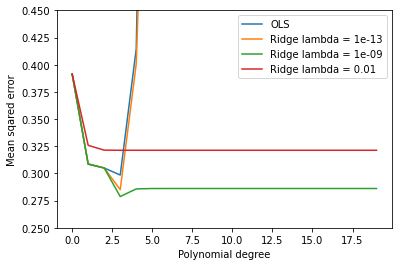

In [79]:
plt.plot(range(len(polynomial_degrees)), test_mse[:, 0], label='OLS')
plt.plot(range(len(polynomial_degrees)), test_mse[:, 1], label='Ridge lambda = ' + str(regularization[0]) )
plt.plot(range(len(polynomial_degrees)), test_mse[:, 2], label='Ridge lambda = ' + str(regularization[1]))
plt.plot(range(len(polynomial_degrees)), test_mse[:, 3], label='Ridge lambda = ' + str(regularization[2]))

plt.legend()
plt.xlabel('Polynomial degree')
plt.ylabel('Mean sqared error')

plt.title('')
plt.ylim(0.25, 0.45)

# Neural Network

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error


#hidden_layers = [[11, 11],[21, 21],[41, 41],[61, 61],[81, 81],[101, 101],[121, 121],[141, 141],[161, 161],[181, 181]]
hidden_layers = [[1, 1], [5, 5], [10, 10], [15, 15], [20, 20], [25, 25], [30, 30], [35, 35]]
                 
train_mse_nn = np.zeros((len(hidden_layers)))
test_mse_nn = np.zeros((train_mse_nn.shape))

z = dBZ_radar
x = np.arange(z.shape[1])
y = np.arange(z.shape[0])
x, y = np.meshgrid(x, y)

x = ( x - np.mean(x) ) / np.var(x)
y = ( y - np.mean(y) ) / np.var(y)
z = ( z - np.mean(z) ) / np.var(z)

k_folds = 7

xyz_shuffle = np.hstack([x.reshape(-1,1), y.reshape(-1,1), z.reshape(-1,1)])
np.random.shuffle(xyz_shuffle) # shuffle along axis 0
xyz_folds = np.array_split(xyz_shuffle, k_folds)

for n_layers in tqdm.tqdm(range(len(hidden_layers))):
    MSE_test = []
    MSE_train = []
            
    for k in range(k_folds):
        xyz_test = xyz_folds[k].copy() # k-th fold is test 
        xyz_train = np.vstack([xyz_folds[f] for f in range(k_folds) if f != k]).copy() # skip k-th fold

        xy_train = xyz_train[:, 0:2]
        z_train = xyz_train[:, 2].reshape(-1, 1)
        xy_test = xyz_test[:, 0:2]
        z_test = xyz_test[:, 2].reshape(-1, 1)    

        dnn = MLPRegressor(hidden_layer_sizes=hidden_layers[n_layers],
                            activation='relu',
                            solver='adam',
                            max_iter=10000)
                
        dnn.fit(xy_train, z_train.ravel())
            
        dnn_zpred_train = dnn.predict(xy_train)
        dnn_zpred_test = dnn.predict(xy_test)            
            
        MSE_test.append( mean_squared_error(z_test.ravel(), dnn_zpred_test ) )
        MSE_train.append( mean_squared_error(z_train.ravel(), dnn_zpred_train ) )
            
    train_mse_nn[n_layers] = np.mean(MSE_train)
    test_mse_nn[n_layers] = np.mean(MSE_test)

100%|█████████████████████████████| 8/8 [00:03<00:00,  2.29it/s]


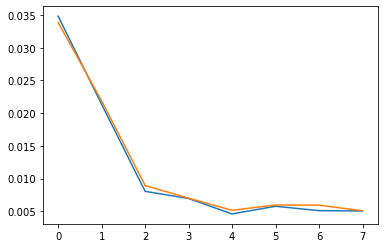

In [8]:
plt.plot(range(len(hidden_layers)), train_mse_nn)
plt.plot(range(len(hidden_layers)), test_mse_nn)

# Decision Tree

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

leafs_list = np.arange(1, 20, 1)
train_mse_dt = np.zeros( leafs_list.shape )
test_mse_dt = np.zeros( leafs_list.shape )

z = dBZ_radar
x = np.arange(z.shape[1])
y = np.arange(z.shape[0])
x, y = np.meshgrid(x, y)

# scale data 
x = ( x - np.mean(x) ) / np.var(x)
y = ( y - np.mean(y) ) / np.var(y)
z = ( z - np.mean(z) ) / np.var(z)

k_folds = 7
xyz_shuffle = np.hstack([x.reshape(-1,1), y.reshape(-1,1), z.reshape(-1,1)])
np.random.shuffle(xyz_shuffle) # shuffle along axis 0
xyz_folds = np.array_split(xyz_shuffle, k_folds)

for leafs in tqdm.tqdm( range(len(leafs_list )) ):
    MSE_test = []
    MSE_train = []
    for k in range(k_folds):     
        # extract folds
        xyz_test = xyz_folds[k].copy() # k-th fold is test 
        xyz_train = np.vstack([xyz_folds[f] for f in range(k_folds) if f != k]).copy() # skip k-th fold

        xy_train = xyz_train[:, 0:2]
        z_train = xyz_train[:, 2].reshape(-1, 1)
        xy_test = xyz_test[:, 0:2]
        z_test = xyz_test[:, 2].reshape(-1, 1)               
            
        clf1 = DecisionTreeRegressor(max_depth=leafs_list[leafs], random_state=42)
        clf1.fit(xy_train, z_train)
        
        skl_predict_test = clf1.predict(xy_test)
        skl_predict_train = clf1.predict(xy_train)
        
        MSE_test.append( mean_squared_error(z_test.ravel(), skl_predict_test ) )
        MSE_train.append( mean_squared_error(z_train.ravel(), skl_predict_train ) )
    
    train_mse_dt[leafs] = np.mean(MSE_train)
    test_mse_dt[leafs] = np.mean(MSE_test)

100%|██████████████████████████| 19/19 [00:00<00:00, 155.72it/s]


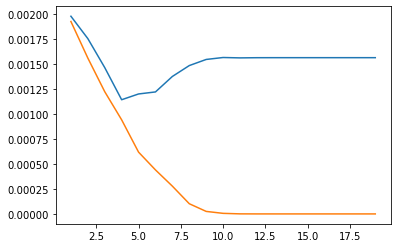

In [10]:
plt.plot(leafs_list, test_mse_dt)
plt.plot(leafs_list, train_mse_dt)